# Image Search By an Artistic Style

This notebook demonstrates how images can be searched by style. One typical business case is an eCommerce webiste that allows to search a poster based on the example uploaded by the user. A user would usually expect to get results that are similar in terms of artisitc style. A real search system would typically mix style similarity with other similarity score such as image subject or category (landscape, still life, etc.) that can also be obtained using deep neural networks.

The implementation is based on a TensorFlow tutorial on Neural Style Transfer [1] which is in turn based on a seminal paper A Neural Algorithm of Artistic Style by Gatys et al. [2].

### Data
We use simple dataset with 32 images from **tensor-house-data** repository.

### References
 1. https://www.tensorflow.org/tutorials/generative/style_transfer
 2. Gatys L., Ecker A., Bethge M. -- A Neural Algorithm of Artistic Style, 2015

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from matplotlib import offsetbox
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import manifold
import scipy as sc

2.7.0


# Load Images

Found [54] images


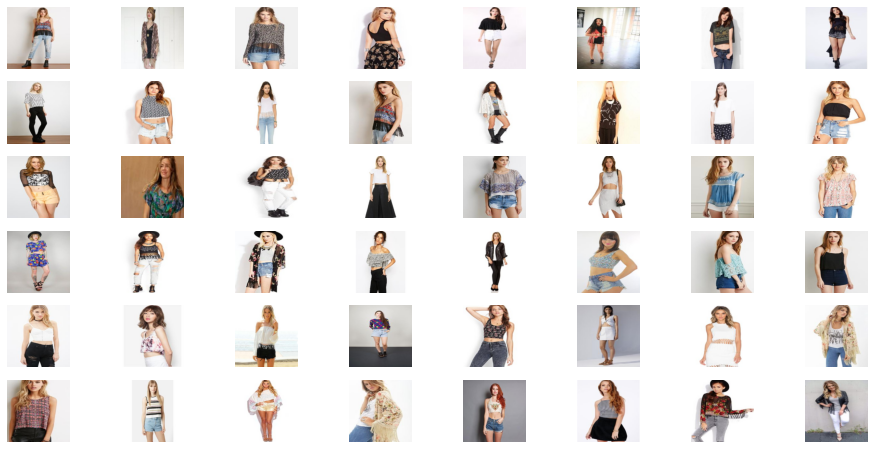

In [2]:
image_paths = glob.glob('D:\Information System\ADM\Assignment 3\imgs\*.jpg')
print(f'Found [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

# Compute and Visualize the Style Embeddings

In [4]:
def load_image(image):
    image = plt.imread(image)
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [400, 400])
    img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
    return img

#
# content layers describe the image subject
#
content_layers = ['block5_conv2'] 

#
# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
#
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
    outputs = [baseline_model.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleModel, self).__init__()
        self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # scale back the pixel values
        inputs = inputs*255.0
        # preprocess them with respect to VGG19 stats
        preprocessed_input = preprocess_input(inputs)
        # pass through the reduced network
        outputs = self.vgg(preprocessed_input)
        # segregate the style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # calculate the gram matrix for each layer
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # assign the content representation and gram matrix in
        # a layer by layer fashion in dicts
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 

#
# Print shapes of the style layers and embeddings
#
image_tensor = load_image(image_paths[0])
style_tensors = image_to_style(image_tensor)
for k,v in style_tensors.items():
    print(f'Style tensor {k}: {v.shape}')
style_embedding = style_to_vec( style_tensors )
print(f'Style embedding: {style_embedding.shape}')

#
# compute styles
#
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style

  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

Style tensor block1_conv1: (1, 64, 64)
Style tensor block2_conv1: (1, 128, 128)
Style tensor block3_conv1: (1, 256, 256)
Style embedding: (86016,)


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:39<00:00,  1.37it/s]


In [5]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

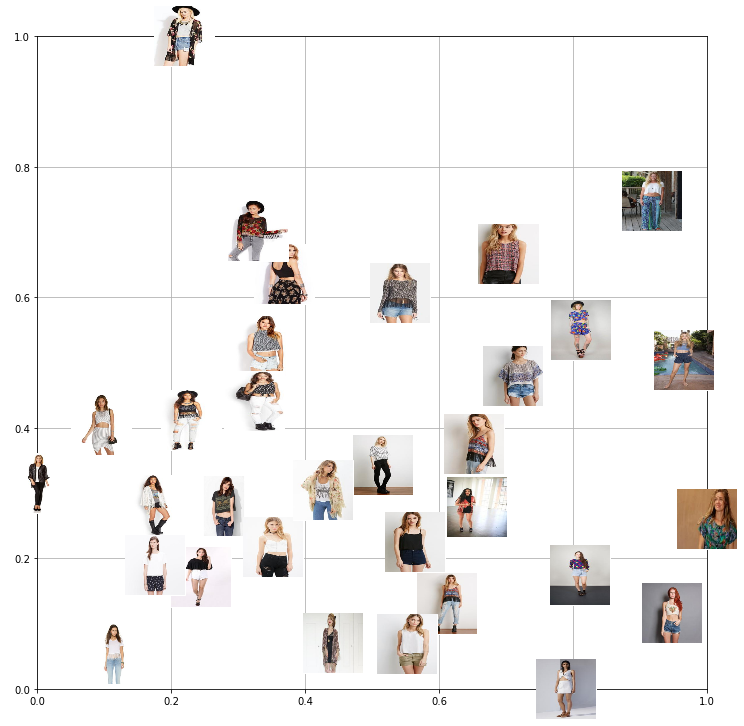

In [6]:
#
# Visualize the 2D-projection of the embedding space with example images (thumbnails)
#
def embedding_plot(X, images, thumbnail_sparsity = 0.005, thumbnail_size = 0.3):
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig, ax = plt.subplots(1, figsize=(12, 12))

    shown_images = np.array([[1., 1.]])
    for i in range(X.shape[0]):
        if np.min(np.sum((X[i] - shown_images) ** 2, axis=1)) < thumbnail_sparsity: continue
        shown_images = np.r_[shown_images, [X[i]]]
        thumbnail = offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r, zoom=thumbnail_size)
        ax.add_artist(offsetbox.AnnotationBbox(thumbnail, X[i], bboxprops = dict(edgecolor='white'), pad=0.0))

    plt.grid(True)
    
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=10, random_state=0)
X_tsne = tsne.fit_transform( np.array(list(image_style_embeddings.values())) )
embedding_plot(X_tsne, images=list(images.values()))

# Search in the Embedding Space

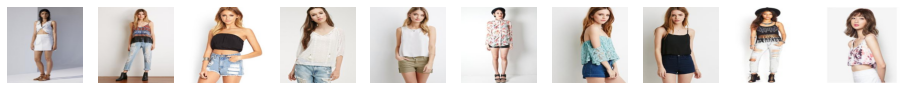

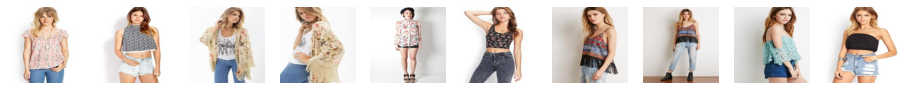

In [8]:
def search_by_style(image_style_embeddings, images, reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()

    plt.show()
    

# images mostly match the reference style, although not perfectly
search_by_style(image_style_embeddings, images, 'img_00000038.jpg')
search_by_style(image_style_embeddings, images, 'img_00000024.jpg')